In [22]:
import pandas as pd
import numpy as np
import pickle

In [23]:
input_path = 'H:\RediMinds\VCQI'
train = pd.read_csv(input_path+"\VCQI_clean_train.csv")
test = pd.read_csv(input_path+"\VCQI_clean_test.csv")

In [24]:
top5 = ['MULTIFOCALITY','CN','CENTERCODE','SOLITARYKIDNEY','AGEATSURGERY']
top10 = ['MULTIFOCALITY','CN','CENTERCODE','SOLITARYKIDNEY','AGEATSURGERY','PREOPCREAT','RENALSINUS','BMI','EDUCATION','ANTERIORORPOSTERIOR']


In [25]:
# Only Keep variables identified as imprtant varaibles in Permutaion Feature Importance calculates for model comprising all variables
# Also keep target variables and Patientnumber
train = train[top10+['INTRA_OP_COMPLICATIONS','PATIENTNUMBER']].copy()
test = test[top10+['INTRA_OP_COMPLICATIONS','PATIENTNUMBER']].copy()

In [26]:
x_train = train.drop(labels=['INTRA_OP_COMPLICATIONS','PATIENTNUMBER'], axis = 'columns').copy()
y_train = train['INTRA_OP_COMPLICATIONS'].copy()
x_test = test.drop(labels=['INTRA_OP_COMPLICATIONS','PATIENTNUMBER'], axis = 'columns').copy()
y_test = test['INTRA_OP_COMPLICATIONS'].copy() 

In [27]:
print("Number of records in trainset {}".format(len(x_train)))
print("Number records in testset {}".format(len(x_test)))
print('% pos labels train {:.2f}'.format(y_train.sum()/len(y_train)))
print('% pos labels test {:.2f}'.format(y_test.sum()/len(y_test)))

Number of records in trainset 1183
Number records in testset 507
% pos labels train 0.06
% pos labels test 0.06


In [28]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1183 entries, 0 to 1182
Data columns (total 12 columns):
MULTIFOCALITY             1183 non-null int64
CN                        1183 non-null int64
CENTERCODE                1183 non-null int64
SOLITARYKIDNEY            1183 non-null int64
AGEATSURGERY              1181 non-null float64
PREOPCREAT                1172 non-null float64
RENALSINUS                1183 non-null int64
BMI                       1105 non-null float64
EDUCATION                 1183 non-null int64
ANTERIORORPOSTERIOR       1183 non-null int64
INTRA_OP_COMPLICATIONS    1183 non-null int64
PATIENTNUMBER             1183 non-null object
dtypes: float64(3), int64(8), object(1)
memory usage: 111.0+ KB


### Defining Pipeline

In [29]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

In [30]:
# ONE HOT CODE data for training

# Import catgeorical variables but keep only those present in the data set
with open (input_path+'\cat_col', 'rb') as fp:
    cat_col = pickle.load(fp)  
cat_col = [x for x in cat_col if x in train.columns]   

# Pipeline for logist Classifier
numeric_features = x_train.select_dtypes('float').columns.tolist()
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')),
                                     ])
categorical_pipe = Pipeline([('onehot', OneHotEncoder(handle_unknown='ignore'))
                            ])
preprocessor_RFC = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features),
                                                   ('cat', categorical_pipe, cat_col)
                                                  ], 
                                     remainder='passthrough')

In [31]:
# Pipeline for logist Classifier
numeric_features = x_train.select_dtypes('float').columns.tolist()
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')),
                                      ('scaler', StandardScaler())
                                     ])
categorical_pipe = Pipeline([('onehot', OneHotEncoder(handle_unknown='ignore'))
                            ])
preprocessor_LR = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features),
                                                   ('cat', categorical_pipe, cat_col)
                                                  ], 
                                     remainder='passthrough')

# Random Forest Classifier

In [32]:
# Random Forest Regressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import math
RFC = RandomForestClassifier(random_state=42)
parameter_dist = {'classifier__n_estimators': [100,200,300,500, 1000], 
                  'classifier__max_features':['sqrt','log2',None],
                  'classifier__min_samples_leaf': [2,3,4,5], 
                  'classifier__class_weight' :['balanced'] 
} 

clf = Pipeline(steps=[('preprocessor', preprocessor_RFC),
                      #('pca',PCA()),
                      ('classifier', RFC)])
classifier_RFR = GridSearchCV(clf, parameter_dist, n_jobs = -1,cv=10, scoring = 'average_precision', return_train_score=True)
results_classifier_RFR = classifier_RFR.fit(x_train, y_train)


In [33]:
y_RFR = classifier_RFR.predict(x_test)
classifier = classifier_RFR
results_RFR = pd.DataFrame(classifier.predict(x_test), columns=['pred_label'])
results_RFR['pred_prob'] =  pd.DataFrame(classifier.predict_proba(x_test))[1]
results_RFR['true_label'] = np.array(y_test)

In [34]:
# Random Forest Classifier Score Raw Data
print(classifier.best_params_)
print("\n Model Best CV score: \n" + str(classifier.best_score_))
print("\n Confusion Matrix : \n"+str(metrics.confusion_matrix(y_test, y_RFR)))
print("\n Classification Report: \n"+ str(metrics.classification_report(y_test, y_RFR)))
print("\n AUC-ROC: \n"+ str(metrics.roc_auc_score(y_test, results_RFR['pred_prob'])))

def calc_aucpr_data(result):
    y_ACTUAL = result['true_label']
    scores_prob = result['pred_prob']
    yhat = result['pred_label']
    precision, recall, thresholds = metrics.precision_recall_curve(y_ACTUAL, scores_prob, pos_label=1)
    prc_auc = metrics.auc(recall,precision)
    return prc_auc

print("\n PR-ROC: \n"+ str(calc_aucpr_data(results_RFR)))
print(metrics.average_precision_score(y_test, results_RFR['pred_prob']))

{'classifier__class_weight': 'balanced', 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 2, 'classifier__n_estimators': 1000}

 Model Best CV score: 
0.4611625947841157

 Confusion Matrix : 
[[471   8]
 [ 14  14]]

 Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       479
           1       0.64      0.50      0.56        28

    accuracy                           0.96       507
   macro avg       0.80      0.74      0.77       507
weighted avg       0.95      0.96      0.95       507


 AUC-ROC: 
0.8308231434536236

 PR-ROC: 
0.5866953148364327
0.5886296657739106


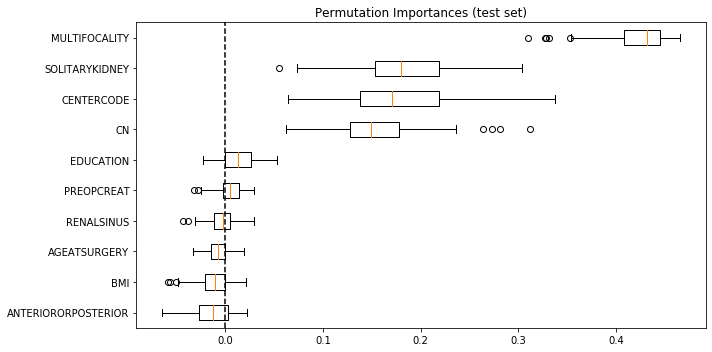

In [35]:
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
result = permutation_importance(classifier_RFR, x_test, y_test, n_repeats=100,
                                random_state=42, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()


fig, ax = plt.subplots(figsize=(10,5))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=x_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
ax.axvline(x = 0,linestyle='--',color='black')
fig.tight_layout()
plt.show()

# Compare Classifiers

C:\Users\anubhav\Anaconda3\envs\Tensorflow\lib\site-packages\ipykernel_launcher.py:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


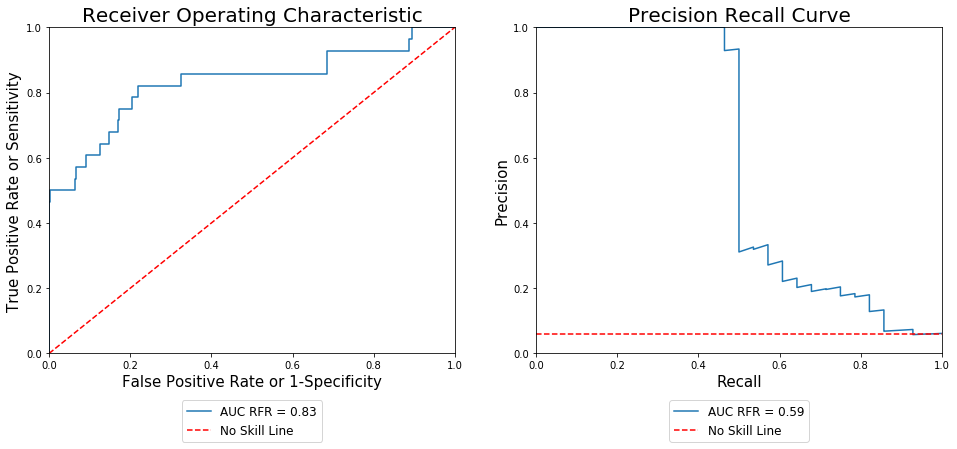

In [36]:
# Plotting AUROC Curve - Calculatae Metrics
from sklearn import metrics
def calc_aucroc_data(result):
    y_ACTUAL= result['true_label']
    scores_prob = result['pred_prob']
    fpr, tpr, thresholds = metrics.roc_curve(y_ACTUAL, scores_prob, pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)
    return fpr, tpr, thresholds, roc_auc

def calc_aucpr_data(result):
    y_ACTUAL = result['true_label']
    scores_prob = result['pred_prob']
    yhat = result['pred_label']
    precision, recall, thresholds = metrics.precision_recall_curve(y_ACTUAL, scores_prob, pos_label=1)
    prc_auc = metrics.auc(recall,precision)
    f1 = metrics.f1_score(y_ACTUAL, yhat)
    ap = metrics.average_precision_score(y_ACTUAL, yhat)
    postives_ratio = round(sum(result['true_label'])/(len(result['true_label'])),2)
    return recall, precision, f1, prc_auc, postives_ratio


fpr_RFR, tpr_RFR, thresholds_RFR, roc_auc_RFR = calc_aucroc_data(results_RFR)
recall_RFR, precision_RFR, f1_RFR, prc_auc_RFR, postives_ratio_RFR = calc_aucpr_data(results_RFR)


import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,6))

# Plotting AUROC Curve - Plot Curve
ax1.set_title('Receiver Operating Characteristic',fontdict={"size":20})
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])
ax1.set_ylabel('True Positive Rate or Sensitivity', fontdict={"size":15})
ax1.set_xlabel('False Positive Rate or 1-Specificity',fontdict={"size":15})
ax1.plot(fpr_RFR, tpr_RFR, label = 'AUC RFR = %0.2f' % roc_auc_RFR)
ax1.plot([0, 1], [0, 1],linestyle='--',color='red', label = 'No Skill Line')
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.125), fontsize = 12)  

# Plotting Precision-Recall Curve - PLot Curve
ax2.set_title('Precision Recall Curve',fontdict={"size":20})
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])
ax2.set_ylabel('Precision',fontdict={"size":15})
ax2.set_xlabel('Recall',fontdict={"size":15})
ax2.plot(recall_RFR, precision_RFR, label = 'AUC RFR = %.2f' % (prc_auc_RFR))
positive_class_ratio = postives_ratio_RFR
ax2.plot([0, 1], [positive_class_ratio, positive_class_ratio],linestyle='--',color='red', label = 'No Skill Line')
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.125),fontsize = 12)

fig.show()



In [37]:
output_path = 'output/models/reduced_varaibles/VCQI/top10'

In [38]:
import os
if not os.path.exists(output_path):
    os.makedirs(output_path)

In [39]:
# Export Random Forest Classifer with Pipeline
from joblib import dump
dump(classifier_RFR, output_path+'/RFR.joblib')

['output/models/reduced_varaibles/VCQI/top10/RFR.joblib']